In [1]:
%run ../__init__.ipynb

382,135 of 486,099 (78.61%) pDockQ 0 to 0.23
79,874 of 486,099 (16.43%) pDockQ 0.23 to 0.5
24,090 of 486,099 (4.96%) pDockQ >0.5


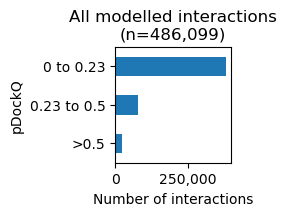

In [2]:
df_models = pd.read_csv(workpath('24.05.17_suppl/suppl_ppi_models.tsv.gz'), sep='\t', keep_default_na=False)

labels = ['0 to 0.23', '0.23 to 0.5', '>0.5']
df_models['pdockq_bin'] = pd.cut(df_models['pdockq'], bins=[0, 0.23, 0.5, 1], labels=labels, include_lowest=True)

for label in labels:
    printlenq(df_models, f'pdockq_bin == "{label}"', 'pDockQ', label)

data_ = df_models['pdockq_bin'].value_counts()
data_.to_frame().plot.barh(legend=None, figsize=(1.5, 1.5))
plt.gca().set_title(f'All modelled interactions\n(n={uf(data_.sum())})')
plt.gca().set_xlabel('Number of interactions')
plt.gca().set_ylabel('pDockQ')
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
plt.gca().invert_yaxis()
plt.savefig('pdockq_counts_.svg', bbox_inches='tight', transparent=True)

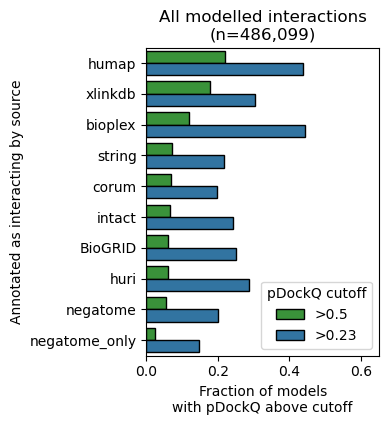

In [3]:
data_ = df_models[['interaction_id', 'pdockq', 'sources']].copy()
data_.loc[data_.eval('sources == "negatome"'), 'sources'] = 'negatome,negatome_only'
data_['sources'] = data_['sources'].map(lambda s: set(s.split(',')))
data_ = data_.explode('sources').query('sources != "otar"')

def apply_(df_):
    return pd.DataFrame.from_records([
        ('>0.5', len(df_.query('pdockq > .5')) / len(df_)),
        ('>0.23', len(df_.query('pdockq > .23')) / len(df_)),
    ], columns=['pDockQ cutoff', 'frac_pdockq'])
data_ = data_.groupby('sources').apply(apply_).reset_index().drop(['level_1'], axis=1)\
    .sort_values(['pDockQ cutoff', 'frac_pdockq'], ascending=[False, False])

plt.figure(figsize=(3, 4))
plt.gca().set_title(f'All modelled interactions\n(n={uf(len(df_models))})')
sns.barplot(data=data_, y='sources', x='frac_pdockq', hue='pDockQ cutoff', orient='h', 
    palette={'>0.23': 'tab:blue', '>0.5': 'tab:green'}, 
    edgecolor='0'
)
plt.gca().set_xlabel('Fraction of models\nwith pDockQ above cutoff')
plt.gca().set_ylabel('Annotated as interacting by source')
plt.gca().set_xlim(0, 0.65)
plt.savefig('pdockq_by_source_.svg', bbox_inches='tight', transparent=True)

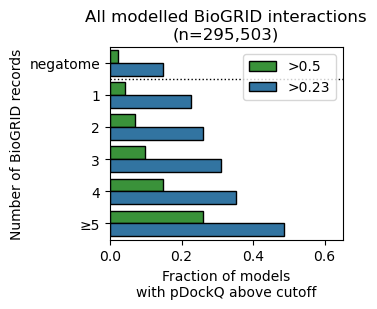

In [4]:
data_ = df_models.query('sources == "negatome" | n_references > 0')[['interaction_id', 'pdockq', 'sources', 'n_references']].copy()

def apply_(df_):
    return pd.DataFrame.from_records([
        ('>0.5', len(df_.query('pdockq > .5')) / len(df_)),
        ('>0.23', len(df_.query('pdockq > .23')) / len(df_)),
    ], columns=['pDockQ cutoff', 'frac_pdockq'])

data_['n_references_max5'] = data_['n_references'].map(lambda x: int(min(x, 5)))
data_ = data_.replace({'n_references_max5': {0: 'negatome', 5: '≥5'}})
data_ = data_.groupby('n_references_max5').apply(apply_).reset_index().drop(['level_1'], axis=1)

n_ = len(df_models.query('n_references > 0'))
plt.figure(figsize=(3, 2.5))
plt.title(f'All modelled BioGRID interactions\n(n={uf(n_)})')
sns.barplot(data=data_, y='n_references_max5', x='frac_pdockq', hue='pDockQ cutoff', orient='h', 
    order=['negatome', 1, 2, 3, 4, '≥5'],
    palette={'>0.23': 'tab:blue', '>0.5': 'tab:green'}, 
    edgecolor='0'
)
plt.gca().set_xlabel('Fraction of models\nwith pDockQ above cutoff')
plt.gca().set_ylabel('Number of BioGRID records')
plt.gca().set_xlim(0, 0.65)
plt.axhline(0.5, color='k', linewidth=1, linestyle='dotted')
plt.legend(loc='upper right')
plt.savefig('pdockq_by_nrecords_biogrid_.svg', bbox_inches='tight', transparent=True)